# Clustering

- Clustering is an unsupervised learning technique that enables exploration of data without labels by putting data into different clusters

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05, random_state=42)


<Axes: >

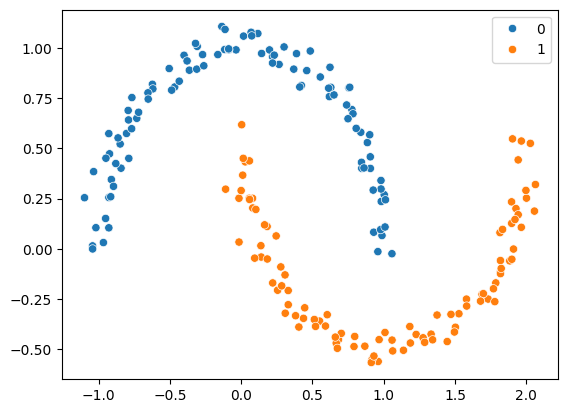

In [ ]:
import seaborn as sns
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)

# K-means clustering

- It puts all points whose closest centroid is centroid X into a cluster corresponding to X
- The decision boundaries between clusters are piecewise linear (i.e., it behaves like a multiclass linear model)

<Axes: >

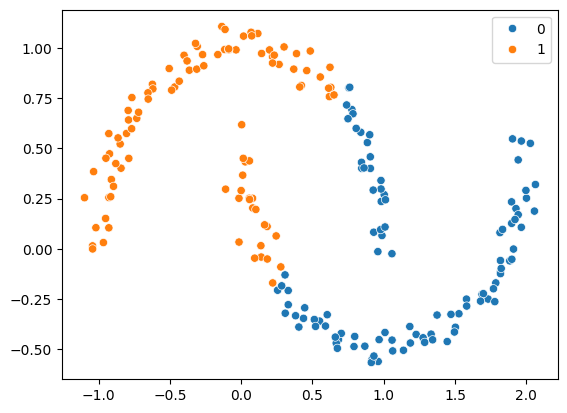

In [ ]:
from sklearn.cluster import KMeans
cluster = KMeans(n_clusters=2)
labels = cluster.fit_predict(X)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=labels)

# DBSCAN clustering

- Nonlinear clustering based on density thresholds
- Requires the data to contain dense patches separated by sparse patches to achieve good effect

<Axes: >

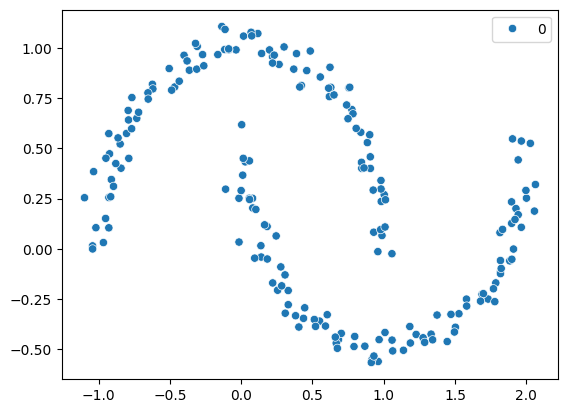

In [ ]:
from sklearn.cluster import DBSCAN
cluster = DBSCAN(eps=10)
labels = cluster.fit_predict(X)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=labels)

# Evaluate

- Why does the model only predict one cluster? eps is too large, so all points are sufficiently close to each other are included in the same cluster
- How to modify the clustering setup to separate the data into its intended structure of two arches on the plot? (shown below)

<Axes: >

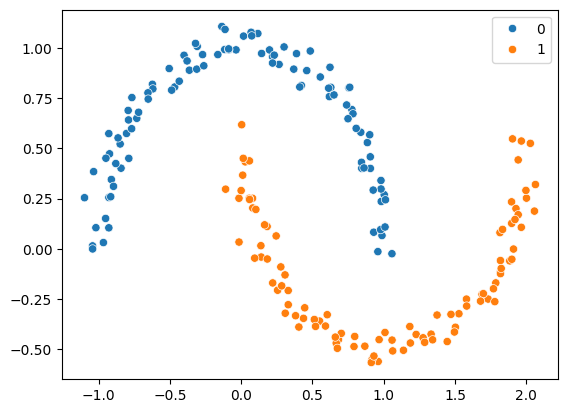

In [ ]:
from sklearn.cluster import DBSCAN
cluster = DBSCAN(eps=0.2) # hint for the above question
labels = cluster.fit_predict(X)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=labels)

# Example: "Eye of Feature Engineering" (modified)

- From the Malaysia AI Olympiad 2025

In [ ]:
# source: https://github.com/jaredliw/ioai-tsp-2025/blob/main/maio-2025/maio_2025_eye_for_feature_engineering.ipynb
import pandas as pd
train_df = pd.read_csv("https://storage.googleapis.com/aiolympiadmy/maio_2025_eye_for_feature_engineering.csv", index_col=0)


In [ ]:
train_df

,feature1,feature2,class
0,55.3846,97.1795,0
1,51.5385,96.0256,0
2,46.1538,94.4872,0
3,42.8205,91.4103,0
4,40.7692,88.3333,0
...,...,...,...
143,80.1538,38.6038,1
144,81.5513,28.6038,1
145,76.8462,34.2962,1
146,83.2821,35.6808,1


<Axes: xlabel='feature1', ylabel='feature2'>

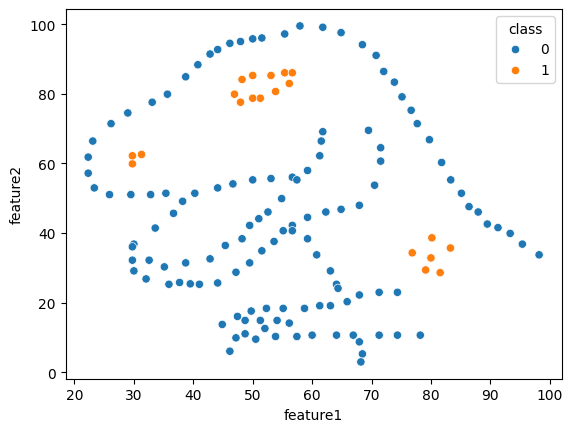

In [ ]:
import seaborn as sns
sns.scatterplot(x=train_df['feature1'], y=train_df['feature2'], hue=train_df['class'])

# Task: Cluster / classify the points

- Predict a label (0 or 1) for each point
- Maximize the F1 score of the prediction against the ground truth dataset
- Don't copy from the label; cluster the data in a way that matches the clustering shown in the label

# Classification Approach

In [ ]:
# try classifiers on cross validation
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
X, y = train_df[['feature1', 'feature2']], train_df['class']
def fit_and_evaluate(reg, X=X, y=y):
    train_preds, train_gt, val_preds, val_gt = [], [], [], []
    for i, (train_idx, val_idx) in enumerate(kfold.split(train_df)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        reg.fit(X_train, y_train)
        train_gt.append(y_train)
        train_preds.append(reg.predict(X_train))
        val_gt.append(y_val)
        val_preds.append(reg.predict(X_val))
    train_preds, train_gt, val_preds, val_gt = np.concatenate(train_preds), np.concatenate(train_gt), np.concatenate(val_preds), np.concatenate(val_gt)
    print(f"Train F1 score: {f1_score(train_gt, train_preds)}")
    print(f"Validation F1 score: {f1_score(val_gt, val_preds)}")

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
models = [LogisticRegression(), LogisticRegression(class_weight='balanced'), KNeighborsClassifier(n_neighbors=1), DecisionTreeClassifier(), LinearSVC(), SVC(kernel='rbf')]
descriptions = ["Logistic regression", "Class-balanced logistic regression", "KNN with k=1", "Decision tree", "Linear SVM", "SVM with RBF kernel"]
for (a, b) in zip(models, descriptions):
    print(b + ": ")
    fit_and_evaluate(a)
    print("=" * 50)

Logistic regression: 
Train F1 score: 0.0
Validation F1 score: 0.0
Class balanced logistic regression: 
Train F1 score: 0.32323232323232326
Validation F1 score: 0.29333333333333333
KNN with k=1: 
Train F1 score: 1.0
Validation F1 score: 1.0
Decision tree: 
Train F1 score: 1.0
Validation F1 score: 0.7619047619047619
Linear SVM: 
Train F1 score: 0.0
Validation F1 score: 0.0
SVM with RBF kernel: 
Train F1 score: 0.0
Validation F1 score: 0.0


# Evaluate

- From visualizing the data points with their corresponding labels (and the bad performance of the linear models), the dataset is far from linearly separable
- KNN and decision tree perform relatively well, meaning that points are grouped into dense clusters of the same label, with sparse regions between the clusters
- Specifically, for KNN with k=1 (which achieved 1.0 F1 cross validation score), the predicted label of an unseen point is the actual label of the closest training sample data point it has seen (since it only considers the top 1 nearest neighbor)
- For each unseen point in the dataset so far, the closest point in training dataset is one of the same label in the same dense region; with the sparse regions between regions of different classes, points from clusters the different class is further away from the unseen point

# Clustering Approach

- The actual problem constrained the solution to logistic regression, which scored 0.0 F1 score by default
- The task for participants was to add features (hence the "feature engineering" in the task title) to the data to allow the logistic regression to achieve better performance
- Some of the best solution approaches involve clustering

<Axes: xlabel='feature1', ylabel='feature2'>

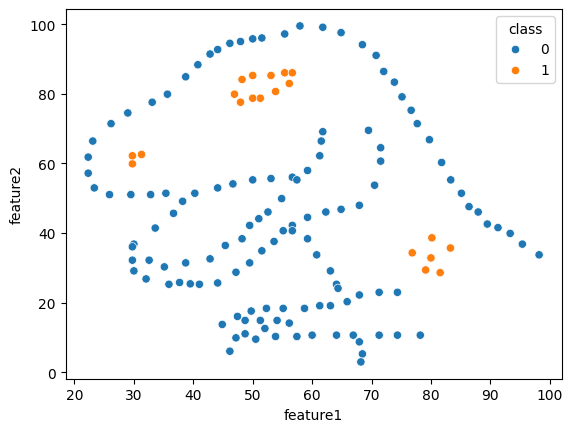

In [ ]:
import seaborn as sns
sns.scatterplot(x=train_df['feature1'], y=train_df['feature2'], hue=train_df['class'])

In [ ]:
def evaluate_fe(feature):
    X, y = train_df[['feature1', 'feature2']], train_df['class']
    X['feature3'] = feature
    reg = LogisticRegression()
    fit_and_evaluate(reg, X=X, y=y)

# Approach 1: KMeans with k=2

- Advantage: constraints the clustering to 2 clusters, which is what is needed for the prediction
- Disadvantage: KMeans behaves like linear models, which perform very poorly on this dataset

KMeans with 2 clusters
Train F1 score: 0.0
Validation F1 score: 0.0


<Axes: xlabel='feature1', ylabel='feature2'>

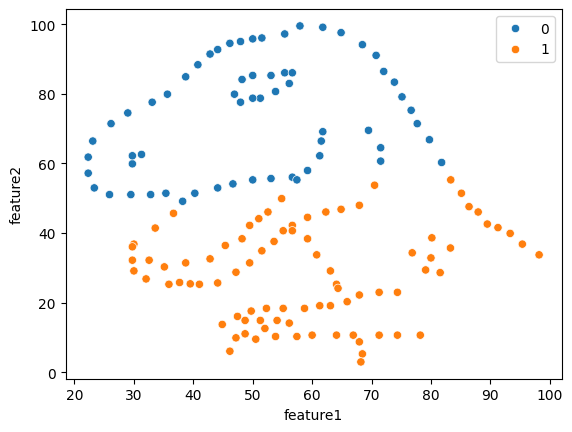

In [ ]:
X, y = train_df[['feature1', 'feature2']], train_df['class']
cluster = KMeans(n_clusters=2)
labels = cluster.fit_predict(X)
print("KMeans with 2 clusters")
evaluate_fe(labels)
sns.scatterplot(x=train_df['feature1'], y=train_df['feature2'], hue=labels) # it isn't really doing any good...

In [ ]:
for i in np.linspace(1, 11, 21):
    X, y = train_df[['feature1', 'feature2']], train_df['class']
    cluster = DBSCAN(eps=i) # need to tune eps
    labels = cluster.fit_predict(X)
    print(f"DBSCAN with eps={i}")
    evaluate_fe(labels)
    print("=" * 50)

DBSCAN with eps=1.0
Train F1 score: 0.0
Validation F1 score: 0.0
DBSCAN with eps=1.5
Train F1 score: 0.0
Validation F1 score: 0.0
DBSCAN with eps=2.0
Train F1 score: 0.0
Validation F1 score: 0.0
DBSCAN with eps=2.5
Train F1 score: 0.0
Validation F1 score: 0.0
DBSCAN with eps=3.0
Train F1 score: 0.0
Validation F1 score: 0.0
DBSCAN with eps=3.5
Train F1 score: 0.0
Validation F1 score: 0.0
DBSCAN with eps=4.0
Train F1 score: 0.0
Validation F1 score: 0.0
DBSCAN with eps=4.5
Train F1 score: 0.0
Validation F1 score: 0.0
DBSCAN with eps=5.0
Train F1 score: 0.8888888888888888
Validation F1 score: 0.8888888888888888
DBSCAN with eps=5.5
Train F1 score: 0.8811188811188811
Validation F1 score: 0.8888888888888888
DBSCAN with eps=6.0
Train F1 score: 0.8652482269503546
Validation F1 score: 0.8235294117647058
DBSCAN with eps=6.5
Train F1 score: 0.8732394366197183
Validation F1 score: 0.8888888888888888
DBSCAN with eps=7.0
Train F1 score: 0.8405797101449275
Validation F1 score: 0.8235294117647058
DBSCA

DBSCAN with eps=8
Train F1 score: 0.9115646258503401
Validation F1 score: 0.918918918918919


<Axes: xlabel='feature1', ylabel='feature2'>

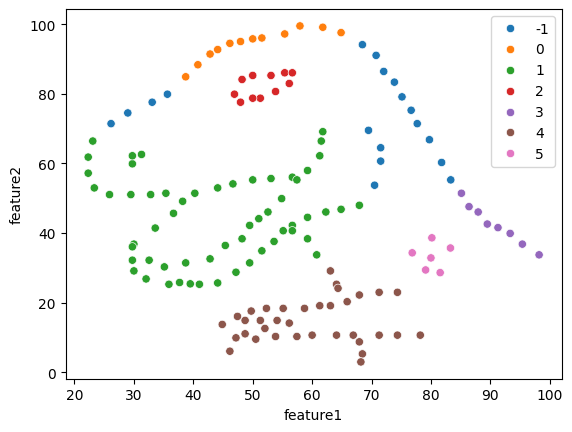

In [ ]:
# best cross validation F1 score: 0.9189 with eps=8.0
X, y = train_df[['feature1', 'feature2']], train_df['class']
cluster = DBSCAN(eps=8)
labels = cluster.fit_predict(X)
print("DBSCAN with eps=8")
evaluate_fe(labels)
sns.scatterplot(x=train_df['feature1'], y=train_df['feature2'], hue=labels, palette="tab10")